In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU or CPU

From train 80%, validation 20%
<br>
Modified to train 60%, validation 20%, test 20% => Using "simple holdout validation"

Reference:
[Time series prediction](https://peaceful0907.medium.com/time-series-prediction-lstm%E7%9A%84%E5%90%84%E7%A8%AE%E7%94%A8%E6%B3%95-ed36f0370204)

![moving_window](Images/moving_window.png)

In [2]:
def create_sequences(data, n_past, n_forecast, col_index):
    X, Y = [], []
    L = len(data)
    for i in range(L-(n_past+n_forecast)): # 1 day every step: i=0, 1, 2, ..., L-(n_past+n_forecast)
        X.append(data[i:i+n_past]) # Input Sequence, using n_past days as input
        Y.append(data[i+n_past:i+n_past+n_forecast][:,col_index]) # Output Sequence, predicting n_forecast days as output

    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

In [3]:
def preprocess(data_trend, train_ratio, test_ratio, n_past, n_forecast, col_index):
    scaler = StandardScaler()
    data_trend = scaler.fit_transform(data_trend) # standardization

    train_index = int(len(data_trend)*train_ratio)
    test_index = int(train_index+len(data_trend)*test_ratio)

    train_data = data_trend[:train_index]
    test_data = data_trend[train_index:test_index]
    val_data = data_trend[test_index:]

    print(f'train_data is data_trend[:{train_index}], shape is {train_data.shape}')
    print(f'test_data is data_trend[{train_index}:{test_index}], shape is {test_data.shape}')
    print(f'val_data is data_trend[{test_index}:], shape is {val_data.shape}')

    X_train, Y_train = create_sequences(train_data, n_past, n_forecast, col_index)
    X_test, Y_test = create_sequences(test_data, n_past, n_forecast, col_index)
    X_val, Y_val = create_sequences(val_data, n_past, n_forecast, col_index)

    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [4]:
df = pd.read_csv('2330.TW.csv')

data = df[[c for c in df.columns if c not in ['Date','Adj Close']]].values

# col_index = 3
# 0: Open, 1: High, 2: Low, 3: Close, 4: Volume
# 5 features to predict "Close"
X_train, Y_train, X_test, Y_test, X_val, Y_val = preprocess(data, train_ratio=0.6, test_ratio=0.2, n_past=20, n_forecast=5, col_index=3)

batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

print(len(train_loader), len(test_loader), len(val_loader))
3571/32, 1190/32, 1191/32

train_data is data_trend[:3571], shape is (3571, 5)
test_data is data_trend[3571:4761], shape is (1190, 5)
val_data is data_trend[4761:], shape is (1191, 5)
111 37 37


(111.59375, 37.1875, 37.21875)

In [5]:
df.head() # before removing Date and Adj Close

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,69.649033,69.649033,68.475182,69.649033,34.844662,200662336736
1,2000-01-05,69.649033,71.214043,68.866341,71.214043,35.627613,402466805912
2,2000-01-06,70.822884,71.214043,69.649033,69.649033,34.844662,197545715802
3,2000-01-07,67.301331,68.475182,66.518639,67.692490,33.865829,235270344752
4,2000-01-10,69.649033,70.431351,68.475182,70.040192,35.040352,276171685539


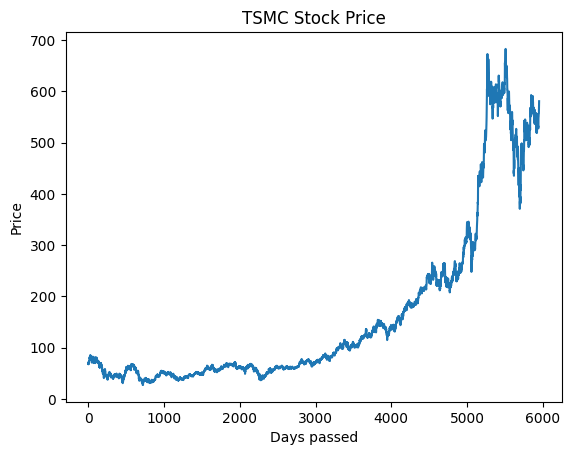

In [6]:
plt.plot(df['Close']) # plot the closing price of TSMC
plt.title('TSMC Stock Price')
plt.xlabel('Days passed')
plt.ylabel('Price')
plt.show()